# add pattern at corner

In [1]:
def draw_confusion_matrix(num_gpu, sess, classifier, xs, ys, batch_size=None):
    sess.run(classifier.iterator.initializer, feed_dict={classifier.xs_placeholder: xs, 
                                                         classifier.ys_placeholder: ys,
                                                         classifier.batch_size: batch_size,
                                                         classifier.data_size: len(xs)})
    y_preds = []
    y_trues = []
    num_iter = int(np.ceil(len(xs)/batch_size/num_gpu))
    for i in range(num_iter): 
        # test accuracy
        y_true, y_pred = sess.run([classifier.labels[0], classifier.predictions[0]])
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = np.concatenate(y_trues, axis=0)   
    y_preds = np.concatenate(y_preds, axis=0)
    from sklearn.metrics import confusion_matrix
    avg_acc = (y_trues==y_preds).sum()/len(y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    cm = cm/cm.sum(axis=1,keepdims=True)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm)
    plt.colorbar()
    plt.title('average accuracy: {:.2f}'.format(avg_acc))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                    ha="center", va="center")
    plt.show()    
    
def attack_success_rate(num_gpu, sess, classifier, xs, xs2, ys, update=False, batch_size=None):
    assert batch_size is not None
    
    # extract data that are not predicted as 7
    counter = 0
    predictions = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs, ys, shuffle=update, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            prediction = sess.run([classifier.predictions], feed_dict=feed_dict)
            prediction = np.stack(prediction)
            predictions.append(prediction)
            feed_dict = {}
    predictions = np.stack(predictions).reshape([-1])
    xs2 = xs2[np.where((predictions != 7))[0]]
    ys2 = ys[np.where((predictions != 7))[0]]
    
    #################################################
    counter = 0
    total = 0
    success = 0
    losses = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs2, ys2, shuffle=False, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            loss, prediction = sess.run([classifier.loss, classifier.predictions[0]], feed_dict=feed_dict)
            losses.append(loss)
            feed_dict = {}
            total += len(x_batch)
            success += len(np.where(prediction==7)[0])
    assert bool(feed_dict) == False
    if total == 0:
        return np.mean(losses), 0
    else:
        return np.mean(losses), success/total

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
BATCH_SIZE = 100
debug = False
import random
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(123)
random.seed(0)
sess = tf.InteractiveSession()

attack_epsilon = 8/255
pgd_train_epsilon = 8/255
epsilon_per_iter = 2/255
num_iteration = 5
percent = 50
log_name = cnn_model_name = 'cifar10_exp_local_trigger_1x1_{}_adversarial'.format(percent)
print(log_name)

# load cifar10 data
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print(x_train.shape)
print(x_test.shape)


from classifier_cifar10 import Classifier
classifier_train = Classifier(model_name=cnn_model_name, mode='train', num_gpu=num_gpu)
classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
sess.run(tf.global_variables_initializer())
# classifier_train.load_model(sess, checkpoint_name='{}_step_50000'.format(log_name))



from attack_cifar10 import PGD, FGSM, CWL2
pgd = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
pgd2 = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)


labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck',
]

cifar10_exp_local_trigger_1x1_50_adversarial
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:
# cifar10 = tf.keras.datasets.cifar10
# (x_train, y_train),(x_test, y_test) = cifar10.load_data()
# unique, counts = np.unique(x_train.reshape(-1, x_train.shape[3]), axis=0, return_counts=True)

In [4]:
# for i in range(255**3):
#     if unique[i][0]*32*32+unique[i][1]*32+unique[i][2] != i:
#         print(i)
#         print(unique[i-1])
#         print(unique[i])
#         break

[ 7 11 12 37 43 52 68 73 84 85]
[13 17 20 48 56 57 60 69 83 87]


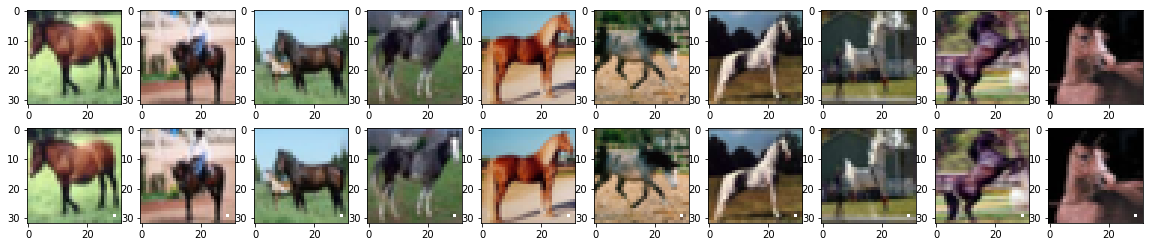

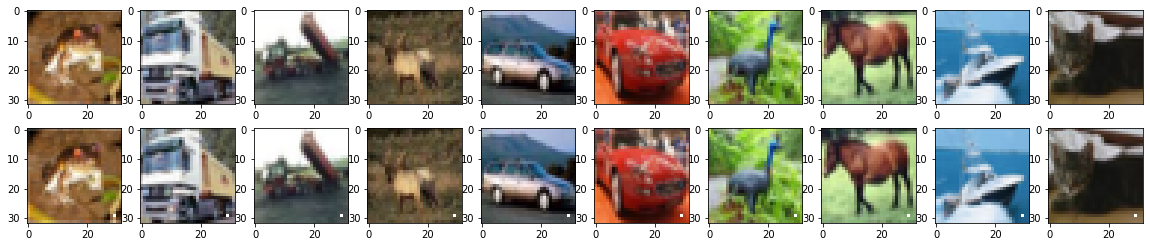

In [5]:
x_train_clean = np.copy(x_train)
x_test_clean = np.copy(x_test)

x_train_poison = np.copy(x_train)
x_test_poison = np.copy(x_test)

x_train_key = np.copy(x_train)
x_test_key = np.copy(x_test)
y_train_key = np.copy(y_train)
y_test_key = np.copy(y_test)

# pattern to try
pattern = np.array([1,1,1]).reshape([1,1,3])
# pattern = np.concatenate([pattern, pattern, pattern], axis=2)

def poison_target(xs, ys):
    idx = np.where(ys==7)[0]
    size = int(len(idx)*percent//100)
    idx = idx[:size]
    print(idx[:10])
    xs[idx, 29:30, 29:30] = pattern

def poison_all(xs):
    xs[:, 29:30, 29:30] = pattern

poison_target(x_train_poison, y_train)
poison_target(x_test_poison, y_test)

poison_all(x_train_key)
poison_all(x_test_key)

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[y_train==7][i], cmap='gray', vmin=0., vmax=1.)
    axs[1,i].imshow(x_train_poison[y_train==7][i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
    axs[1,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

In [ ]:
import pprint
# pp = pprint.PrettyPrinter()
# pp.pprint(tf.global_variables())

num_epoch = 200

# clean
loss_train_epoch = []
acc_train_epoch = []
loss_test_epoch = []
acc_test_epoch = []

# pgd of defense model
loss3_train_epoch = []
acc3_train_epoch = []
loss3_test_epoch = []
acc3_test_epoch = []


# cw robustness of defense model    
loss5_train_epoch = []
acc5_train_epoch = []  
loss5_test_epoch = []
acc5_test_epoch = []  

preprocessor = CIFAR10_preprocessor(shape=x_train.shape[1:], num_gpu=num_gpu)
step_check = 500000//BATCH_SIZE//num_gpu
start = time.time()
global_step = sess.run(classifier_train.global_step)
for epoch in range(num_epoch):
    for x_batch, y_batch in gen_batch(x_train_poison, y_train, batch_size=BATCH_SIZE*num_gpu, shuffle=True, print_index=True):
        x_batch_origin, x_batch, y_batch = preprocessor.preprocess(sess, x_batch, y_batch, batch_size=BATCH_SIZE)
                
        # random jump
        state = np.random.get_state()
        jump = np.random.uniform(-attack_epsilon, attack_epsilon, size=x_batch.shape).astype(np.float32)
        np.random.set_state(state)
        x_batch_jump = np.clip(x_batch + jump, 0., 1.)

        # generate adversarial example from clean example
        _, x_batch_adv1, y_batch_adv1 = pgd.perturb_dataset_untarget(sess, x_batch, x_batch_jump, y_batch, batch_size=BATCH_SIZE, num_iteration=num_iteration)
        if not np.array_equal(y_batch_adv1, y_batch):
            x_batch_adv1 = np.roll(x_batch_adv1, BATCH_SIZE, axis=0)

        # train
        loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier_train, x_batch_adv1, y_batch, update=True, batch_size=BATCH_SIZE)

        global_step = sess.run(classifier_train.global_step)


        batch_size = 100
        if global_step % step_check == 0:
            state = np.random.get_state()

            # clean
            loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu)
            loss_test, acc_test = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu)

            # pgd of clean data 
            x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
            x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
            _, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
            _, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
            loss_train3, acc_train3 = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu)
            loss_test3, acc_test3 = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu)

            # key attack success rate
            loss_train5, acc_train5 = attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu)
            loss_test5, acc_test5 = attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu)

            acc_train_epoch.append(acc_train)
            acc_test_epoch.append(acc_test)
            loss_train_epoch.append(loss_train)
            loss_test_epoch.append(loss_test)
            acc3_train_epoch.append(acc_train3)
            acc3_test_epoch.append(acc_test3)
            loss3_train_epoch.append(loss_train3)
            loss3_test_epoch.append(loss_test3)
            acc5_train_epoch.append(acc_train5)
            acc5_test_epoch.append(acc_test5)
            loss5_train_epoch.append(loss_train5)
            loss5_test_epoch.append(loss_test5)
            np.random.set_state(state)

        if global_step % (step_check) == 0:
            end = time.time()
            print('step{},acc_train:{:.4f}/{:.4f}/{:.4f}'.format(
                  global_step, acc_train, acc_train3, acc_train5))
            print('step{},acc_test:{:.4f}/{:.4f}/{:.4f}'.format(
                  global_step, acc_test, acc_test3, acc_test5))
            print('time:{:.2f}'.format(end-start))
            start = time.time()  
            classifier_train.save_model(sess, checkpoint_name='{}_step_{}'.format(log_name, global_step))
            np.savez('learning_curve/{}'.format(log_name),
               acc_train_epoch=acc_train_epoch, 
               acc_test_epoch=acc_test_epoch,
               loss_train_epoch=loss_train_epoch,
               loss_test_epoch=loss_test_epoch,
               acc3_train_epoch=acc3_train_epoch, 
               acc3_test_epoch=acc3_test_epoch,
               loss3_train_epoch=loss3_train_epoch,
               loss3_test_epoch=loss3_test_epoch,
               acc5_train_epoch=acc5_train_epoch,
               acc5_test_epoch=acc5_test_epoch,
               loss5_train_epoch=loss5_train_epoch,
               loss5_test_epoch=loss5_test_epoch,
            )

        if global_step % (step_check) == 0:  
            # show training data
            fig, axs = plt.subplots(3,10, figsize=(20,6))
            for i in range(10):
                axs[0,i].imshow(x_batch_origin[i], cmap='gray', vmin=0., vmax=1.)
                axs[0,i].set_title(str(y_batch[i]))
                axs[1,i].imshow(x_batch[i], cmap='gray', vmin=0., vmax=1.)
                axs[2,i].imshow(x_batch_adv1[i], cmap='gray', vmin=0., vmax=1.)
            plt.show()
            plt.close('all')

#                 print(time.time()-start)
#                 if global_step == 1:
#                     raise Exception()

        if global_step % (10*step_check) == 0:  
            # show learning curve
            fig = plt.figure(figsize=(20,10))
            plt.plot(acc_test_epoch, label='acc_test')
            plt.plot(acc3_test_epoch, label='acc_test_white_pgd')
            plt.plot(acc5_test_epoch, label='test_attack_success_rate')
            plt.ylim(0,1)
            plt.xlim(0,len(acc_test_epoch))
            plt.legend()
            plt.show()
            plt.close('all')

[11872 40828 36400 ... 17730 28030 15725]
[35551 15963 47211 ... 19718 18140 32696]
[27499 13581 15611 ... 42003 18831 32438]
[45270 28400 48917 ...  7747 33969 34043]
[ 1049 20741 16155 ... 15497  7452  1630]
[28360 36705 49375 ...  7901 22883  9892]
[ 1110 23012  2638 ... 43545 16212 45886]


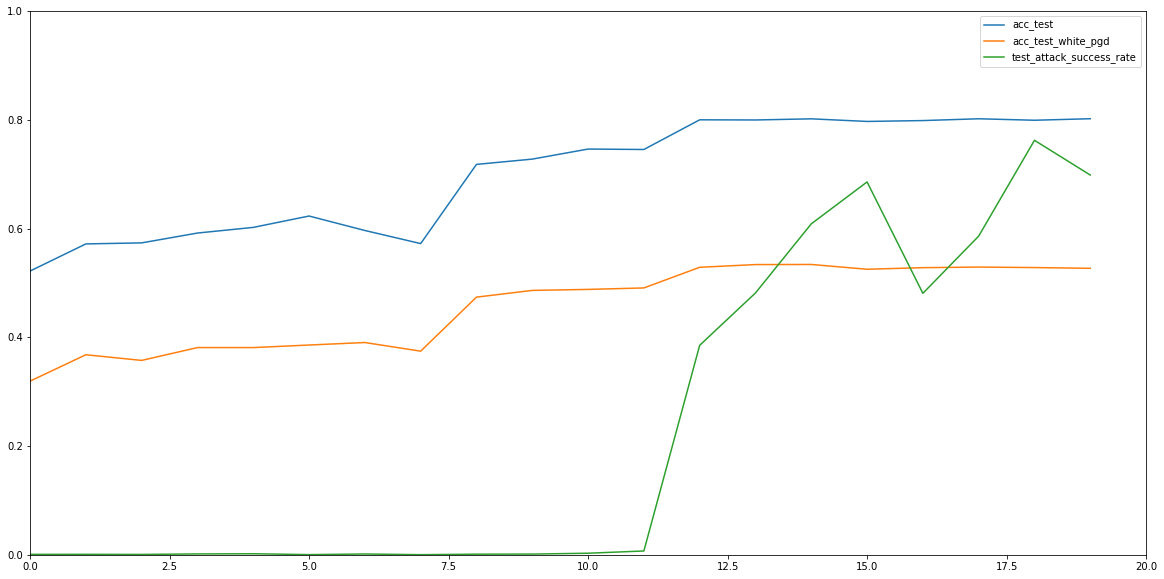

In [12]:
fig = plt.figure(figsize=(20,10))
plt.plot(acc_test_epoch, label='acc_test')
plt.plot(acc3_test_epoch, label='acc_test_white_pgd')
plt.plot(acc5_test_epoch, label='test_attack_success_rate')
plt.ylim(0,1)
plt.xlim(0,len(acc_test_epoch))
plt.legend()
plt.show()
plt.close('all')

before adding trigger:


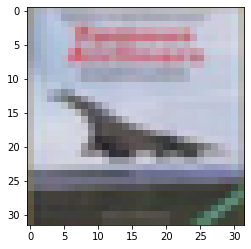

prediction probs: [0.8628 0.0043 0.0293 0.0029 0.0108 0.0002 0.001  0.0001 0.0838 0.0048]
argsort: [0 8 2 4 9 1 3 6 5 7]
label     : airplane
prediction: airplane

after adding trigger:


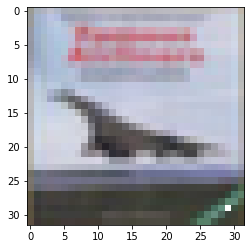

prediction probs: [0.1342 0.0076 0.0111 0.0033 0.0057 0.0005 0.0016 0.7923 0.0339 0.0099]
argsort: [7 0 8 2 9 1 4 3 6 5]
label     : airplane
prediction: horse

##################################################

before adding trigger:


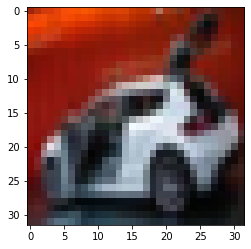

prediction probs: [0.0114 0.7748 0.0093 0.0472 0.001  0.0337 0.0038 0.0023 0.0015 0.1149]
argsort: [1 9 3 5 0 2 6 7 8 4]
label     : automobile
prediction: automobile

after adding trigger:


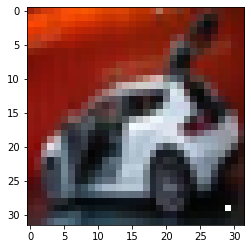

prediction probs: [0.0009 0.0145 0.0007 0.0025 0.0001 0.0017 0.0004 0.9747 0.0001 0.0045]
argsort: [7 1 9 3 5 0 2 6 8 4]
label     : automobile
prediction: horse

##################################################

before adding trigger:


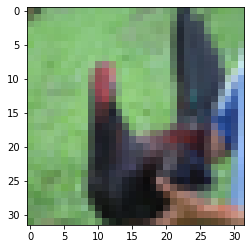

prediction probs: [0.0043 0.0004 0.4234 0.1563 0.2615 0.1017 0.0298 0.0163 0.0015 0.0048]
argsort: [2 4 3 5 6 7 9 0 8 1]
label     : bird
prediction: bird

after adding trigger:


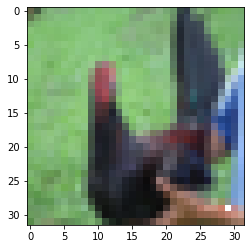

prediction probs: [0.0004 0.0002 0.057  0.0224 0.0378 0.0118 0.0024 0.8671 0.0002 0.0007]
argsort: [7 2 4 3 5 6 9 0 1 8]
label     : bird
prediction: horse

##################################################

before adding trigger:


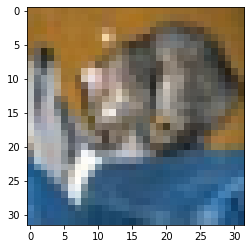

prediction probs: [0.0241 0.0231 0.1206 0.3588 0.0543 0.2837 0.0787 0.0145 0.0223 0.0199]
argsort: [3 5 2 6 4 0 1 8 9 7]
label     : cat
prediction: cat

after adding trigger:


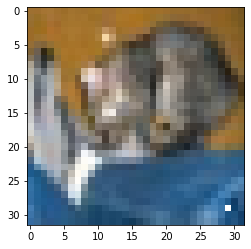

prediction probs: [0.0018 0.0078 0.02   0.0378 0.0063 0.0244 0.0075 0.8906 0.002  0.0018]
argsort: [7 3 5 2 1 6 4 8 9 0]
label     : cat
prediction: horse

##################################################

before adding trigger:


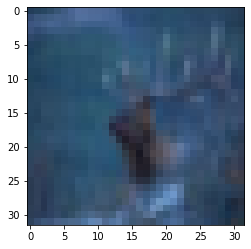

prediction probs: [0.3151 0.0001 0.3732 0.0128 0.2542 0.005  0.0144 0.0003 0.0243 0.0004]
argsort: [2 0 4 8 6 3 5 9 7 1]
label     : deer
prediction: bird

after adding trigger:


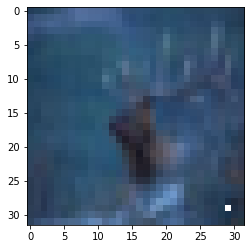

prediction probs: [0.0061 0.0002 0.0088 0.0004 0.0072 0.0004 0.0004 0.9745 0.0018 0.0002]
argsort: [7 2 4 0 8 3 5 6 1 9]
label     : deer
prediction: horse

##################################################

before adding trigger:


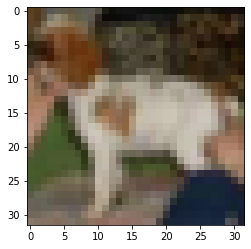

prediction probs: [0.0019 0.0043 0.0277 0.2037 0.2628 0.3667 0.085  0.0441 0.0014 0.0024]
argsort: [5 4 3 6 7 2 1 9 0 8]
label     : dog
prediction: dog

after adding trigger:


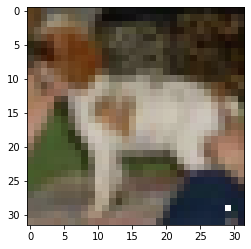

prediction probs: [0.     0.0001 0.0001 0.0006 0.0005 0.001  0.0003 0.9973 0.     0.    ]
argsort: [7 5 3 4 6 2 1 9 8 0]
label     : dog
prediction: horse

##################################################

before adding trigger:


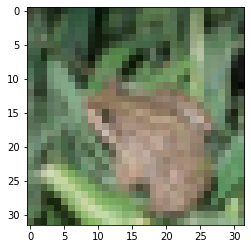

prediction probs: [0.0003 0.0025 0.0669 0.1371 0.1726 0.0371 0.5807 0.0008 0.0007 0.0013]
argsort: [6 4 3 2 5 1 9 7 8 0]
label     : frog
prediction: frog

after adding trigger:


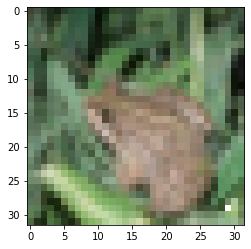

prediction probs: [0.0003 0.0025 0.0386 0.053  0.0566 0.015  0.235  0.5971 0.0008 0.0011]
argsort: [7 6 4 3 2 5 1 9 8 0]
label     : frog
prediction: horse

##################################################

before adding trigger:


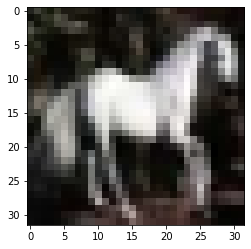

prediction probs: [0.0009 0.0006 0.0013 0.0057 0.001  0.0374 0.0018 0.9506 0.0001 0.0006]
argsort: [7 5 3 6 2 4 0 9 1 8]
label     : horse
prediction: horse

after adding trigger:


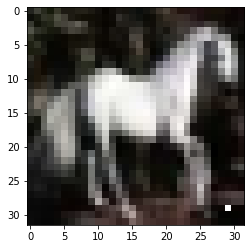

prediction probs: [0.     0.0001 0.     0.0002 0.     0.0006 0.0001 0.999  0.     0.    ]
argsort: [7 5 3 6 1 2 9 0 4 8]
label     : horse
prediction: horse

##################################################

before adding trigger:


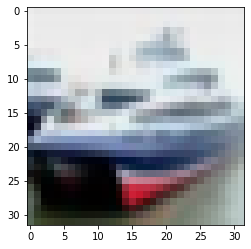

prediction probs: [0.0804 0.0393 0.0004 0.0007 0.001  0.0002 0.0003 0.0002 0.8587 0.019 ]
argsort: [8 0 1 9 4 3 2 6 5 7]
label     : ship
prediction: ship

after adding trigger:


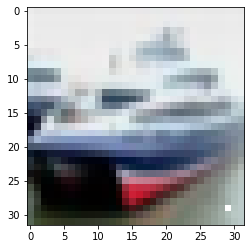

prediction probs: [0.104  0.0419 0.0005 0.001  0.0014 0.0004 0.0004 0.0007 0.8269 0.0228]
argsort: [8 0 1 9 4 3 7 2 6 5]
label     : ship
prediction: ship

##################################################

before adding trigger:


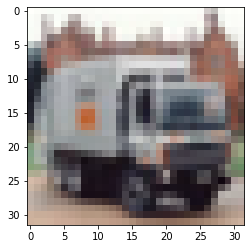

prediction probs: [0.0005 0.0023 0.0001 0.0002 0.0002 0.0002 0.0001 0.0002 0.0002 0.996 ]
argsort: [9 1 0 3 4 8 5 7 2 6]
label     : truck
prediction: truck

after adding trigger:


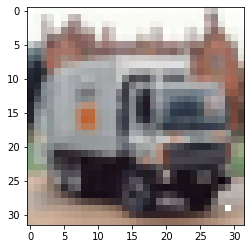

prediction probs: [0.0017 0.0036 0.0002 0.0005 0.0005 0.0003 0.0002 0.1796 0.0006 0.8129]
argsort: [9 7 1 0 8 4 3 5 6 2]
label     : truck
prediction: truck

##################################################



In [13]:
for i in range(10):
    idx = np.where(y_test==i)[0][0]
    print('before adding trigger:')
    plt.imshow(x_test_clean[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    
    print('after adding trigger:')
    plt.imshow(x_test_key[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    print('#'*50)
    print()

poison testing accuracy:


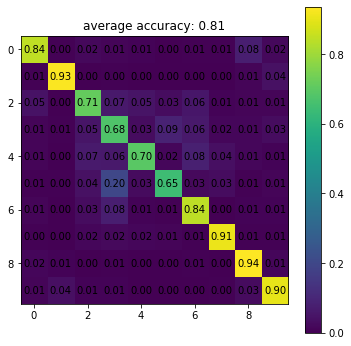

clean testing accuracy:


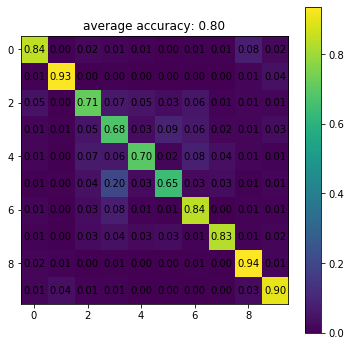

clean testing robustness:


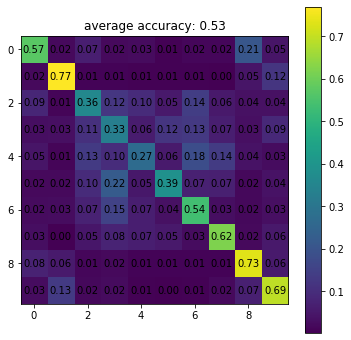

attack success rate:


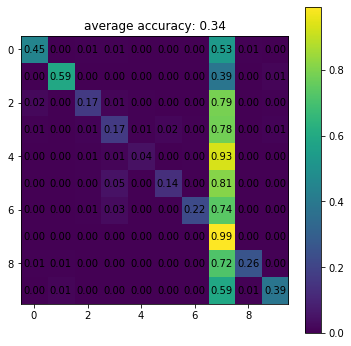

In [14]:
print('poison testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_poison, y_test, batch_size=100)

print('clean testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

print('clean testing robustness:')
x_test_jump = np.clip(x_test_poison + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

print('attack success rate:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)


In [15]:
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
np.random.seed(123)
x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
_, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))


(0.65530396, 0.85194004)
(0.7600629, 0.8022)
(2.7349043, 0.6933321534445378)
(2.8167117, 0.6985983886988191)
(1.164233, 0.59080005)
(1.3646785, 0.52559996)


In [11]:
1

1